# Imports and paths

In [4]:
import os
import sys

# root path
ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the project root to the Python path
if ROOT not in sys.path:
    sys.path.append(ROOT)

import polars as pl
import pandas as pd
import numpy as np
import json

In [5]:
from config import PRODUCTS_PARQUET_PATH, PRODUCTS_PARQUET_PATH_IMPUTED, ALL_PRODS_TRAINTEST_PATH
from src.data.loaders import PolarsLoader

## Products

In [4]:
prods = pl.read_parquet(PRODUCTS_PARQUET_PATH, low_memory=True)
print(prods.shape)
print(prods.head())
print(prods.null_count())

(43692, 6)
shape: (5, 6)
┌──────────┬─────────────────────────────────┬────────────┬──────────┬─────────────┬────────┐
│ discount ┆ embedding                       ┆ partnumber ┆ color_id ┆ cod_section ┆ family │
│ ---      ┆ ---                             ┆ ---        ┆ ---      ┆ ---         ┆ ---    │
│ u8       ┆ list[f32]                       ┆ u16        ┆ u16      ┆ u8          ┆ u16    │
╞══════════╪═════════════════════════════════╪════════════╪══════════╪═════════════╪════════╡
│ 0        ┆ [-0.134014, -0.120043, … -0.08… ┆ 32776      ┆ 85       ┆ 4           ┆ 73     │
│ 0        ┆ [-0.094927, -0.107294, … -0.04… ┆ 41431      ┆ 135      ┆ 4           ┆ 73     │
│ 0        ┆ [-0.129044, -0.077246, … 0.002… ┆ 39419      ┆ 339      ┆ 4           ┆ 73     │
│ 1        ┆ [-0.127833, -0.133868, … -0.09… ┆ 36087      ┆ 135      ┆ 4           ┆ 73     │
│ 1        ┆ [-0.140929, -0.125828, … -0.04… ┆ 34132      ┆ 3        ┆ 4           ┆ 73     │
└──────────┴───────────────────────

In [5]:
prods['partnumber'].n_unique()

43692

### Drop products not present in the training/test set

In [6]:
# Load from JSON
with open(ALL_PRODS_TRAINTEST_PATH, 'r') as f:
    all_prods = json.load(f)

prods = prods.filter(pl.col('partnumber').is_in(all_prods))
prods['partnumber'].n_unique()

42265

### Null imputation

**Family mean (embedding)**

In [7]:
from typing import List
# # Helper function to calculate mean embedding for a group
def calc_mean_embedding(embeddings: List[np.ndarray]) -> np.ndarray:
    valid_embeddings = [e for e in embeddings if e is not None and len(e) > 0]
    return np.mean(valid_embeddings, axis=0) if valid_embeddings else np.nan

# Calculate family mean embeddings
family_means = (
    prods
    .group_by('family')
    .agg(pl.col('embedding'))
    .with_columns(
        mean_embedding=pl.col('embedding').map_elements(calc_mean_embedding, return_dtype=pl.List(pl.Float32))
    )
)

In [8]:
prods = prods.join(family_means.select(['family', 'mean_embedding']), on='family', how='left')
prods = prods.with_columns([
    pl.when(pl.col('embedding').is_null())
        .then(pl.col('mean_embedding'))
        .otherwise(pl.col('embedding'))
        .alias('embedding')
])
prods.null_count()

discount,embedding,partnumber,color_id,cod_section,family,mean_embedding
u32,u32,u32,u32,u32,u32,u32
0,8,0,0,87,0,8


**Overall mean (embedding)**

In [9]:
# Calculate family mean embeddings
overall_mean = calc_mean_embedding(prods['embedding'])
overall_mean

array([-0.08372563,  0.16689125, -0.10456386, ...,  0.15249544,
        0.00691349,  0.04625465], shape=(1280,), dtype=float32)

In [10]:
prods = prods.with_columns([
    pl.when(pl.col("embedding").is_null())
        .then(pl.lit(pl.Series([overall_mean])))  # Convert numpy array to Polars Series
        .otherwise(pl.col('embedding'))
        .alias('embedding')
]).drop('mean_embedding')
prods.null_count()

discount,embedding,partnumber,color_id,cod_section,family
u32,u32,u32,u32,u32,u32
0,0,0,0,87,0


In [11]:
# # Inspect lengths of embeddings
# prods_imputed = prods.to_pandas()
# embedding_lengths = prods_imputed['embedding'].apply(lambda x: len(x) if x is not None else None)

# # Check for unique lengths
# print(embedding_lengths.unique())  # Should ideally show one value, e.g., [1280]

# # Find problematic rows (if any)
# problematic_rows = prods_imputed[embedding_lengths != 1280]
# print(problematic_rows)

**cod_section**

In [12]:
def fill_section_mode(products):
    # Calculate mode by family
    family_modes = (
        products.group_by('family')
        .agg(
            mode_section=pl.col('cod_section').cast(pl.String).mode().first()
        )
    )

    # Join back to fill nulls
    result = products.join(
        family_modes,
        on='family',
        how='left'
    ).with_columns(
        cod_section=pl.col('cod_section').fill_null(pl.col('mode_section').cast(pl.UInt8))
    ).drop('mode_section')

    return result

In [13]:
prods = fill_section_mode(prods)
prods.null_count()

discount,embedding,partnumber,color_id,cod_section,family
u32,u32,u32,u32,u32,u32
0,0,0,0,0,0


In [14]:
# prods.write_parquet(PRODUCTS_PARQUET_PATH_IMPUTED)

### PCA embeddings

In [15]:
# prods_imputed = prods.clone()

In [6]:
prods_imputed = pl.read_parquet(PRODUCTS_PARQUET_PATH_IMPUTED)
prods_imputed.head()

discount,embedding,partnumber,color_id,cod_section,family
u8,list[f32],u16,u16,u8,u16
0,"[-0.134014, -0.120043, … -0.080103]",32776,85,4,73
0,"[-0.094927, -0.107294, … -0.044575]",41431,135,4,73
0,"[-0.129044, -0.077246, … 0.002047]",39419,339,4,73
1,"[-0.127833, -0.133868, … -0.091194]",36087,135,4,73
1,"[-0.140929, -0.125828, … -0.043056]",34132,3,4,73


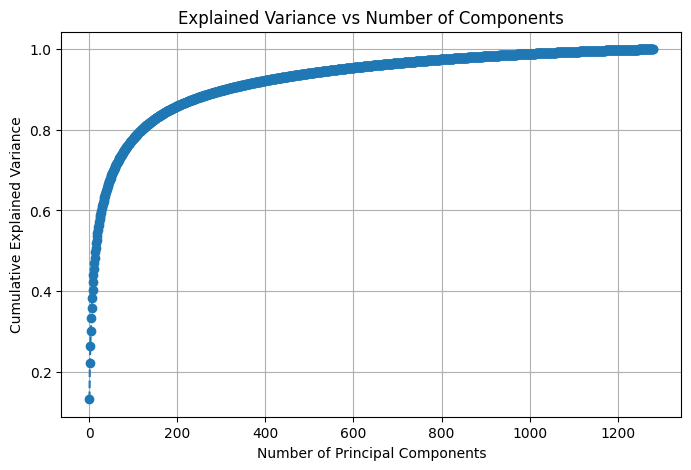

Number of components to retain 95% variance: 566


In [18]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'products['embedding']' contains the embeddings as lists of floats
embeddings = np.stack(prods_imputed['embedding'].to_numpy())

# Normalize embeddings to ensure consistency
normalized_embeddings = normalize(embeddings)

# Apply PCA
pca = PCA()
pca.fit(normalized_embeddings)

# Explained variance ratio
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs Number of Components')
plt.grid()
plt.show()

# Determine the number of components for 95% variance
n_components = np.argmax(explained_variance >= 0.95) + 1
print(f"Number of components to retain 95% variance: {n_components}")

In [24]:
# Analizar diferentes thresholds
for threshold in [0.7, 0.8, 0.85, 0.9, 0.95]:
    pca = PCA(n_components=threshold)
    pca.fit(normalized_embeddings)
    print(f"Para {threshold*100}% de varianza necesitas {pca.n_components_} componentes")

Para 70.0% de varianza necesitas 56 componentes
Para 80.0% de varianza necesitas 119 componentes
Para 85.0% de varianza necesitas 184 componentes
Para 90.0% de varianza necesitas 308 componentes
Para 95.0% de varianza necesitas 566 componentes


## Feature engineering

In [7]:
from sklearn.preprocessing import normalize

def normalize_embedding(products_df: pl.DataFrame) -> pl.DataFrame:
    
    # Normalized embedding
    embeddings = np.stack(products_df['embedding'].to_numpy())
    normalized = normalize(embeddings)
    products_df = products_df.with_columns([pl.Series('embedding', normalized)])
    
    return products_df

def create_initial_extra_features(df: pl.DataFrame) -> pl.DataFrame:

    df = normalize_embedding(df)
    
    df = df.with_columns([
        # Categorical frequencies
        pl.col('color_id').count().over('family').alias('color_family_frequency'),
        # Proporciones
        (pl.col('discount').mean().over('family')).alias('family_discount_rate').cast(pl.Float32),
        (pl.col('discount').mean().over('cod_section')).alias('section_discount_rate').cast(pl.Float32),
        # Número de colores únicos en la familia
        pl.col('color_id').n_unique().over('family').alias('family_unique_colors')
    ])
    
    return df

prods_eng = create_initial_extra_features(prods_imputed)
prods_eng.head()

discount,embedding,partnumber,color_id,cod_section,family,color_family_frequency,family_discount_rate,section_discount_rate,family_unique_colors
u8,"array[f32, 1280]",u16,u16,u8,u16,u32,f32,f32,u32
0,"[-0.013066, -0.011704, … -0.00781]",32776,85,4,73,4612,0.041197,0.025261,271
0,"[-0.009753, -0.011023, … -0.00458]",41431,135,4,73,4612,0.041197,0.025261,271
0,"[-0.012109, -0.007248, … 0.000192]",39419,339,4,73,4612,0.041197,0.025261,271
1,"[-0.01299, -0.013603, … -0.009267]",36087,135,4,73,4612,0.041197,0.025261,271
1,"[-0.013687, -0.012221, … -0.004182]",34132,3,4,73,4612,0.041197,0.025261,271


## Top10 similar products (run on Kaggle)

In [6]:
from config import PROD_TOP_SIMILAR_PATH
top10 = pl.read_parquet(PROD_TOP_SIMILAR_PATH)
top10.head()

product,similar_product,similarity
i64,i64,f64
32776,14863,0.959358
32776,39419,0.955601
32776,35047,0.955337
32776,9284,0.947821
32776,9002,0.943472


In [8]:
print("Total products: ", top10['product'].n_unique())

Total products:  42265
